### https://arxiv.org/pdf/2402.08593

In [1]:
import json
import random
import os
import pickle
import time
import shutil
import sys
import uuid
from collections import defaultdict
from datetime import timedelta, datetime
from glob import glob
from itertools import product
from pyspark.sql import functions as sf
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.storagelevel import StorageLevel
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, recall_score, RocCurveDisplay

from sklearn.preprocessing import normalize

import igraph as ig
import leidenalg as la
import numpy as np
import pandas as pd
import xgboost as xgb

import settings as s

os.environ["EXT_DATA_TYPE_FOLDER"] = "ethereum"

from common import get_weights, delete_large_vars, MULTI_PROC_STAGING_LOCATION
from communities import get_communities_spark
from features import (
    generate_features_spark, generate_features_udf_wrapper,
    SCHEMA_FEAT_UDF
)

%load_ext autoreload
%autoreload 2

In [2]:
start_script = time.time()

In [3]:
if (
    sys.version_info.major,
    sys.version_info.minor,
    sys.version_info.micro,
) != (3, 11, 8):
    raise EnvironmentError(
        "Only runs efficiently on Python 3.11.8 (Tested on: Conda 24.1.2 | Apple M3 Pro)"
    )

In [4]:
SPARK_CONF = [
    ("spark.driver.memory", "32g"),
    ("spark.worker.memory", "32g"),
    ("spark.driver.maxResultSize", "32g"),
    ("spark.driver.bindAddress", "127.0.0.1"),
    ("spark.sql.execution.arrow.pyspark.enabled", "true"),
    ("spark.network.timeout", "600s"),
    ("spark.sql.autoBroadcastJoinThreshold", -1)
]

shutil.rmtree("artifacts", ignore_errors=True)
spark = (
    SparkSession.builder.appName("testing")
    .config(conf=SparkConf().setAll(SPARK_CONF))
    .getOrCreate()
)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/29 18:11:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
TRAIN_PERC = 0.65
VALIDATION_PERC = 0.15
TEST_PERC = 0.2

KEEP_TOP_N = 100

assert(sum([TRAIN_PERC, VALIDATION_PERC, TEST_PERC]) == 1)

location_main = os.path.join("features", os.environ["EXT_DATA_TYPE_FOLDER"])
# shutil.rmtree(location_main, ignore_errors=True)

location_communities_leiden = f"{location_main}{os.sep}communities_leiden.parquet"

location_features_leiden = f"{location_main}{os.sep}features_leiden.parquet"
location_features_ego = f"{location_main}{os.sep}features_ego.parquet"
location_features_2_hop = f"{location_main}{os.sep}features_2_hop.parquet"
location_features_2_hop_out = f"{location_main}{os.sep}features_2_hop_out.parquet"
location_features_2_hop_in = f"{location_main}{os.sep}features_2_hop_in.parquet"
location_features_2_hop_combined = f"{location_main}{os.sep}features_2_hop_combined.parquet"
location_features_source = f"{location_main}{os.sep}features_source.parquet"
location_features_target = f"{location_main}{os.sep}features_target.parquet"

location_flow_dispense = f"{location_main}{os.sep}location_flow_dispense.parquet"
location_flow_passthrough = f"{location_main}{os.sep}location_flow_passthrough.parquet"
location_flow_sink = f"{location_main}{os.sep}location_flow_sink.parquet"

location_comm_as_source_features = f"{location_main}{os.sep}comm_as_source_features.parquet"
location_comm_as_target_features = f"{location_main}{os.sep}comm_as_target_features.parquet"
location_comm_as_passthrough_features = f"{location_main}{os.sep}comm_as_passthrough_features.parquet"
location_comm_as_passthrough_features_reverse = f"{location_main}{os.sep}comm_as_passthrough_features_reverse.parquet"

location_features_node_level = f"{location_main}{os.sep}features_node_level.parquet"
location_features_edges = f"{location_main}{os.sep}features_edges.parquet"

location_features_edges_train = f"{location_main}{os.sep}features_edges_train.parquet"
location_features_edges_valid = f"{location_main}{os.sep}features_edges_valid.parquet"
location_features_edges_test = f"{location_main}{os.sep}features_edges_test.parquet"

location_train_trx_features = f"{location_main}{os.sep}train_trx_features.parquet"
location_valid_trx_features = f"{location_main}{os.sep}valid_trx_features.parquet"
location_test_trx_features = f"{location_main}{os.sep}test_trx_features.parquet"

location_train_features = f"{location_main}{os.sep}train_features.parquet"
location_valid_features = f"{location_main}{os.sep}valid_features.parquet"
location_test_features = f"{location_main}{os.sep}test_features.parquet"

try:
    os.makedirs(location_main)
except FileExistsError:
    pass

In [6]:
data = pd.read_parquet(s.INPUT_DATA_FILE)
# Only interested when "target" is phishing
phishing_nodes = set(data.loc[data["is_phishing"], "target"].unique())
assert len(phishing_nodes) == 1164

In [7]:
%%time

source_firsts = data.groupby("source").agg(first_trx=("timestamp", "min"))
target_firsts = data.groupby("target").agg(first_trx=("timestamp", "min"))
active_since = source_firsts.join(target_firsts, lsuffix="_left", how="outer").fillna(datetime.now())
active_since.loc[:, "active_since"] = active_since.apply(lambda x: min([x["first_trx_left"], x["first_trx"]]), axis=1)
active_since = active_since.loc[:, ["active_since"]]
active_since.sort_values("active_since", inplace=True)

number_of_train_accounts = int(np.floor(active_since.shape[0] * TRAIN_PERC))
number_of_validation_accounts = int(np.floor(active_since.shape[0] * VALIDATION_PERC))
train_accounts = set(active_since.head(number_of_train_accounts).index.tolist())
assert len(train_accounts) == number_of_train_accounts
remaining = active_since.loc[~active_since.index.isin(train_accounts), :].sort_values("active_since")
validation_accounts = set(remaining.head(number_of_validation_accounts).index.tolist())
assert len(validation_accounts) == number_of_validation_accounts
test_accounts = set(active_since.index) - train_accounts - validation_accounts
print(f"{len(train_accounts):,} | {len(validation_accounts):,} | {len(test_accounts):,}")
assert sorted(train_accounts | validation_accounts | test_accounts) == sorted(active_since.index)

1,932,767 | 446,023 | 594,699
CPU times: user 24.3 s, sys: 291 ms, total: 24.6 s
Wall time: 24.6 s


In [8]:
train = data.loc[data["source"].isin(train_accounts) & data["target"].isin(train_accounts), :]
validation = data.loc[data["source"].isin(validation_accounts) & data["target"].isin(validation_accounts), :]
test = data.loc[data["source"].isin(test_accounts) & data["target"].isin(test_accounts), :]
print(
    round(train.shape[0] / data.shape[0], 2), 
    round(validation.shape[0] / data.shape[0], 2), 
    round(test.shape[0] / data.shape[0], 2)
)
train_count, validation_count, test_count = train.shape[0], validation.shape[0], test.shape[0]

assert set(train.index).intersection(validation.index) == set()
assert set(validation.index).intersection(test.index) == set()
assert set(train.index).intersection(test.index) == set()

0.74 0.05 0.03


In [9]:
%%time

edges = data.groupby(["source", "target"]).agg(
    amount_usd=("amount_usd", "sum")
).reset_index()
weights = get_weights(edges)
edges_agg = edges.set_index(["source", "target"]).join(
    weights.set_index(["source", "target"]), how="left"
).reset_index()
edges_agg.loc[:, "amount_usd_weighted"] = (
    edges_agg.loc[:, "amount_usd"] * 
    (edges_agg.loc[:, "weight"] / edges_agg.loc[:, "weight"].max())
)

CPU times: user 31.3 s, sys: 665 ms, total: 32 s
Wall time: 32 s


In [10]:
# Later on, we will reset the variables (to free up memory), while still keeping these intact
to_keep = %who_ls
to_keep = list(to_keep)

In [11]:
# %%time

TOP_N = 50
# NUM_HOPS = 5

# data_input = spark.createDataFrame(edges_agg)
# nodes_source = set(edges_agg["source"].unique())
# nodes_target = set(edges_agg["target"].unique())
# nodes_passthrough = nodes_source.intersection(nodes_target)

# %run generate_flow_features.ipynb

# comm_as_source_features.to_parquet(location_comm_as_source_features)
# comm_as_target_features.to_parquet(location_comm_as_target_features)
# comm_as_passthrough_features.to_parquet(location_comm_as_passthrough_features)
# comm_as_passthrough_features_reverse.to_parquet(location_comm_as_passthrough_features_reverse)

# del comm_as_source_features
# del comm_as_target_features
# del comm_as_passthrough_features
# del comm_as_passthrough_features_reverse

In [12]:
# %%time

# print("Constructing Leiden communities")

# graph = ig.Graph.DataFrame(edges_agg.loc[:, ["source", "target", "amount_usd_weighted"]], use_vids=False, directed=True)
# nodes_mapping = {x.index: x["name"] for x in graph.vs()}
# communities_leiden = la.find_partition(
#     graph, la.ModularityVertexPartition, n_iterations=100, weights="amount_usd_weighted"
# )
# communities_leiden = [[nodes_mapping[_] for _ in x] for x in communities_leiden]
# communities_leiden = [(str(uuid.uuid4()), set(x)) for x in communities_leiden]
# sizes_leiden = [len(x[1]) for x in communities_leiden]

# with open(location_communities_leiden, "wb") as fl:
#     pickle.dump(communities_leiden, fl)

In [13]:
with open(location_communities_leiden, "rb") as fl:
    communities_leiden = pickle.load(fl)

In [14]:
data = spark.createDataFrame(data)

In [ ]:
%%time

data_agg_weights = get_weights(
    data.groupby(["source", "target"])
    .agg(
        sf.sum("amount_usd").alias("amount_usd")
    ).toPandas()
)

data_agg_weights_rev = data_agg_weights.rename(
    columns={"target": "source", "source": "target"}
).loc[:, ["source", "target", "weight"]]
data_agg_weights_ud = pd.concat([data_agg_weights, data_agg_weights_rev], ignore_index=True)
data_agg_weights_ud = data_agg_weights_ud.groupby(["source", "target"]).agg(weight=("weight", "sum")).reset_index()

data_agg_weights_ud.sort_values("weight", ascending=False, inplace=True)
grouped_ud = data_agg_weights_ud.groupby("source").head(KEEP_TOP_N).reset_index(drop=True)
grouped_ud = grouped_ud.groupby("source").agg(targets=("target", set))

total = grouped_ud.index.nunique()
nodes_neighborhoods = {}
for index, (source, targets) in enumerate(grouped_ud.iterrows()):
    community_candidates = {source}
    for target in targets["targets"]:
        community_candidates |= (grouped_ud.loc[target, "targets"] | {target})
    nodes_neighborhoods[source] = set(community_candidates)
    if not (index % 250_000):
        print(index, total)

del data_agg_weights_rev
del data_agg_weights_ud
del grouped_ud

In [ ]:
%%time

print("Constructing 2-hop communities")

communities_2_hop = get_communities_spark(
    nodes_neighborhoods,
    ig.Graph.DataFrame(edges_agg.loc[:, ["source", "target", "amount_usd_weighted"]], use_vids=False, directed=True), 
    os.cpu_count(), spark, 2, "all", 0.01, "amount_usd_weighted"
)
sizes_2_hop = [len(x[1]) for x in communities_2_hop]
del nodes_neighborhoods

In [ ]:
%%time

ts_min = data.select(sf.min("timestamp").alias("x")).collect()[0]["x"] - timedelta(minutes=1)
data_graph_agg = data.groupby(["source", "target"]).agg(
    sf.sum("num_transactions").alias("num_transactions"),
    sf.sum("amount_usd").alias("amount_usd"),
    sf.collect_list(sf.array((sf.col("timestamp") - ts_min).cast("long"), sf.col("amount_usd"))).alias("timestamps_amounts"),
)
data_graph_agg_sdf = data_graph_agg.persist(StorageLevel.DISK_ONLY)
print(data_graph_agg_sdf.count())
data_graph_agg = data_graph_agg_sdf.toPandas()
index = ["source", "target"]
edges_agg.loc[:, index + ["weight"]].set_index(index)
data_graph_agg = data_graph_agg.set_index(index).join(
    edges_agg.loc[:, index + ["weight"]].set_index(index), how="left"
).reset_index()
data_graph_agg.loc[:, "amount_usd_weighted"] = (
    data_graph_agg.loc[:, "amount_usd"] * 
    (data_graph_agg.loc[:, "weight"] / data_graph_agg.loc[:, "weight"].max())
)

In [ ]:
graph = ig.Graph.DataFrame(data_graph_agg, use_vids=False, directed=True)

In [ ]:
%%time

print("Leiden communitites features creation")

communities_leiden = [(x, y) for x, y in communities_leiden if len(y) > 1]
features_leiden = generate_features_spark(communities_leiden, graph, spark)
features_leiden = features_leiden.rename(columns={"key": "key_fake"})
communities_leiden_dict = dict(communities_leiden)
features_leiden.loc[:, "key"] = features_leiden.loc[:, "key_fake"].apply(lambda x: communities_leiden_dict[x])
features_leiden = features_leiden.explode("key")
del features_leiden["key_fake"]
features_leiden.set_index("key").to_parquet(location_features_leiden)

In [ ]:
%%time

print("2-hop communitites features creation")

features_2_hop = generate_features_spark(communities_2_hop, graph, spark)
features_2_hop.set_index("key").to_parquet(location_features_2_hop)

In [ ]:
del graph

In [ ]:
%%time

print("Temporal flows features creation")

edges_totals = data.select("source", "target", "amount_usd").groupby(
    ["source", "target"]
).agg(sf.count("amount_usd").alias("amount_usd")).toPandas()
edges_totals = edges_totals.sort_values("amount_usd", ascending=False).reset_index(drop=True)
left_edges = spark.createDataFrame(edges_totals.groupby("target").head(TOP_N).loc[:, ["source", "target"]])
right_edges = spark.createDataFrame(edges_totals.groupby("source").head(TOP_N).loc[:, ["source", "target"]])

columns = ["source", "target", "timestamp", "amount_usd"]

left = left_edges.select(sf.col("source").alias("src"), sf.col("target").alias("tgt")).join(
    data.select(*columns),
    on=(sf.col("src") == sf.col("source")) & (sf.col("tgt") == sf.col("target")),
    how="left"
).drop("src", "tgt").persist(StorageLevel.DISK_ONLY)
select = []
for column in left.columns:
    select.append(sf.col(column).alias(f"left_{column}"))
left = left.select(*select)
right = right_edges.select(sf.col("source").alias("src"), sf.col("target").alias("tgt")).join(
    data.select(*columns),
    on=(sf.col("src") == sf.col("source")) & (sf.col("tgt") == sf.col("target")),
    how="left"
).drop("src", "tgt").persist(StorageLevel.DISK_ONLY)

print(left.count(), right.count())

flows_temporal = left.join(
    right,
    (left["left_target"] == right["source"]) &
    (left["left_timestamp"] <= right["timestamp"]),
    how="inner"
).groupby(["left_source", "left_target", "source", "target"]).agg(
    sf.sum("left_amount_usd").alias("left_amount_usd"),
    sf.sum("amount_usd").alias("amount_usd"),
).drop("left_target").select(
    sf.col("left_source").alias("dispense"),
    sf.col("source").alias("passthrough"),
    sf.col("target").alias("sink"),
    sf.least("left_amount_usd", "amount_usd").alias("amount_usd"),
)

aggregate = [
    sf.sum("amount_usd").alias("amount_sum"),
    sf.mean("amount_usd").alias("amount_mean"),
    sf.median("amount_usd").alias("amount_median"),
    sf.max("amount_usd").alias("amount_max"),
    sf.stddev("amount_usd").alias("amount_std"),
    sf.countDistinct("dispense").alias("dispense_count"),
    sf.countDistinct("passthrough").alias("passthrough_count"),
    sf.countDistinct("sink").alias("sink_count"),
]
for flow_location, flow_type in [
    (location_flow_dispense, "dispense"), (location_flow_passthrough, "passthrough"), (location_flow_sink, "sink")
]:
    print(flow_type)
    flows_temporal_stats = flows_temporal.groupby(flow_type).agg(*aggregate).toPandas()
    flows_temporal_cyclic_stats = flows_temporal.where(
        (sf.col("dispense") == sf.col("sink"))
    ).groupby(flow_type).agg(*aggregate).toPandas()
    flows_temporal_stats = flows_temporal_stats.set_index(flow_type).join(
        flows_temporal_cyclic_stats.set_index(flow_type),
        how="left", rsuffix="_cycle"
    )
    flows_temporal_stats.index.name = "key"
    flows_temporal_stats.to_parquet(flow_location)
    del flows_temporal_stats
    del flows_temporal_cyclic_stats

left.unpersist()
right.unpersist()

del edges_totals
del left_edges
del right_edges

In [ ]:
%%time

print("1-hop-source features creation")

features_source = spark.createDataFrame(data_graph_agg).withColumn(
    "key", sf.col("source")
).repartition(os.cpu_count() * 5, "key").groupby("key").applyInPandas(
    generate_features_udf_wrapper(False), schema=SCHEMA_FEAT_UDF
).toPandas()
features_source = pd.DataFrame(features_source["features"].apply(json.loads).tolist())
features_source.columns = [f"{s.G_1HOP_PREFIX}{x}" if x != "key" else x for x in features_source.columns]
features_source.set_index("key").to_parquet(location_features_source)

In [ ]:
%%time

print("1-hop-target features creation")

features_target = spark.createDataFrame(data_graph_agg).withColumn(
    "key", sf.col("target")
).repartition(os.cpu_count() * 5, "key").groupby("key").applyInPandas(
    generate_features_udf_wrapper(False), schema=SCHEMA_FEAT_UDF
).toPandas()
features_target = pd.DataFrame(features_target["features"].apply(json.loads).tolist())
features_target.columns = [f"{s.G_1HOP_PREFIX}{x}" if x != "key" else x for x in features_target.columns]
features_target.set_index("key").to_parquet(location_features_target)

In [ ]:
del data_graph_agg

In [ ]:
ENABLED_FEATURES = [
    ("leiden", location_features_leiden),
    ("2_hop", location_features_2_hop),
    ("as_source", location_features_source),
    ("as_target", location_features_target),
    ("comm_as_source_features", location_comm_as_source_features),
    ("comm_as_target_features", location_comm_as_target_features),
    ("comm_as_passthrough_features", location_comm_as_passthrough_features),
    ("comm_as_passthrough_features_reverse", location_comm_as_passthrough_features_reverse),
    ("flow_dispense", location_flow_dispense),
    ("flow_passthrough", location_flow_passthrough),
    ("flow_sink", location_flow_sink),   
]

In [ ]:
all_features = pd.DataFrame()
all_features.index.name = "key"

for feature_group, location in ENABLED_FEATURES:
    all_features = all_features.join(
        pd.read_parquet(location), how="outer", rsuffix=f"_{feature_group}"
    )

all_features.to_parquet(location_features_node_level)
print("Features:", all_features.shape)
del all_features

In [ ]:
all_features = pd.read_parquet(location_features_node_level)

In [ ]:
constants = []
for column in all_features.columns:
    if all_features[column].nunique(dropna=True) <= 1:
        del all_features[column]
        constants.append(column)
print(f"Deleted {len(constants)} constant columns")

In [ ]:
medians = {}
for column in all_features.columns:
    medians[column] = np.nanmedian(all_features[column])

In [ ]:
delta = round(time.time() - start_script)
print(f"Script executed in {timedelta(seconds=delta)}")

In [ ]:
%%time

print("Training the anomaly detection model")

anomalies = all_features.loc[:, []]
model_ad = IsolationForest(n_estimators=10_000)
anomalies.loc[:, "anomaly_score"] = -model_ad.fit(
    all_features.fillna(medians)
).decision_function(all_features.fillna(medians))
anomalies.loc[:, "anomaly_score"] += abs(anomalies.loc[:, "anomaly_score"].min()) + 1e-10
anomalies.loc[:, "anomaly_score"] /= anomalies.loc[:, "anomaly_score"].max()

In [ ]:
# NOTE: Not being used for "ethereum" data

n_components = 100
pca = PCA(n_components=n_components)
all_features_dim_reduced = pd.DataFrame(
    pca.fit_transform(normalize(all_features.fillna(0), norm="l1", axis=1)),
    index=all_features.index
)
explained_variance_ratio = round(sum(pca.explained_variance_ratio_) * 100, 2)
assert explained_variance_ratio > 99
print(n_components, explained_variance_ratio)
all_features_dim_reduced.columns = [
    f"pca_{x + 1}" for x in all_features_dim_reduced.columns
]

In [ ]:
%%time

print(f"Generating edge features")

to_select = ["source", "target", "timestamp", "num_transactions", "amount", "amount_usd", "is_zero_transaction"]

edges_features_input = data.select(to_select).groupby(
    ["source", "target"]
).agg(
    sf.sum("num_transactions").alias("num_transactions"), 
    sf.sum("amount").alias("amount"),
    sf.sum("amount_usd").alias("amount_usd"),
    sf.count(sf.when(sf.col("is_zero_transaction"), 1).otherwise(0)).alias("count_zero_transactions"),
    sf.count(sf.when(sf.col("is_zero_transaction"), 0).otherwise(1)).alias("count_non_zero_transactions"),
    (sf.unix_timestamp(sf.max("timestamp")) - sf.unix_timestamp(sf.min("timestamp"))).alias("related_for"),
).persist(StorageLevel.DISK_ONLY)
_ = edges_features_input.count()

edge_features = edges_features_input.toPandas()
edge_features.to_parquet(location_features_edges)
del edge_features

In [ ]:
edge_features = pd.read_parquet(location_features_edges)

In [ ]:
%%time

train_edges = train.loc[:, ["source", "target"]].drop_duplicates().set_index(
    ["source", "target"]
)
valid_edges = validation.loc[:, ["source", "target"]].drop_duplicates().set_index(
    ["source", "target"]
)
test_edges = test.loc[:, ["source", "target"]].drop_duplicates().set_index(
    ["source", "target"]
)

train_features = train_edges.join(
    edge_features.set_index(["source", "target"]), how="left"
).reset_index()
validation_features = valid_edges.join(
    edge_features.set_index(["source", "target"]), how="left"
).reset_index()
test_features = test_edges.join(
    edge_features.set_index(["source", "target"]), how="left"
).reset_index()

In [ ]:
def save_edge_features(features_in, location):
    features_in = features_in.set_index("target").join(
        anomalies, how="left"
    ).reset_index().set_index("source").join(
        anomalies, how="left", rsuffix="_source"
    ).reset_index().set_index("target").join(
        all_features, how="left", rsuffix="_target"
    ).reset_index().set_index("source").join(
        all_features, how="left", rsuffix="_source"
    ).reset_index()
    features_in.loc[:, "anom_scores_diff"] = features_in.loc[:, "anomaly_score"] - features_in.loc[:, "anomaly_score_source"]
    features_in.loc[:, "anom_scores_min"] = np.array(
        [
            features_in.loc[:, "anomaly_score"].values, 
            features_in.loc[:, "anomaly_score_source"].values
        ],
    ).min(axis=0)
    features_in.loc[:, "anom_scores_max"] = np.array(
        [
            features_in.loc[:, "anomaly_score"].values, 
            features_in.loc[:, "anomaly_score_source"].values
        ],
    ).max(axis=0)
    features_in.loc[:, "anom_scores_mean"] = np.array(
        [
            features_in.loc[:, "anomaly_score"].values, 
            features_in.loc[:, "anomaly_score_source"].values
        ],
    ).mean(axis=0)
    features_in.to_parquet(location)

In [ ]:
%%time

save_edge_features(train_features, location_features_edges_train)

In [ ]:
%%time

save_edge_features(validation_features, location_features_edges_valid)

In [ ]:
%%time

save_edge_features(test_features, location_features_edges_test)

In [21]:
def save_trx_features(data_in, location):
    columns = [
        "source",
        "target",
        "amount",
        "amount_usd",
        "is_zero_transaction",
        "source_dispensation",
        "target_accumulation",
        "source_positive_balance",
        "source_negative_balance",
        "target_positive_balance",
        "target_negative_balance",
        "source_active_for",
        "target_active_for",
        "is_phishing",
    ]
    trx_features = data_in.loc[:, columns]
    trx_features.to_parquet(location)
    del trx_features

In [22]:
%%time

save_trx_features(train, location_train_trx_features)
save_trx_features(validation, location_valid_trx_features)
save_trx_features(test, location_test_trx_features)

CPU times: user 3.41 s, sys: 124 ms, total: 3.53 s
Wall time: 3.38 s


In [ ]:
# To free up memory for training

to_reset = %who_ls
to_reset = list(to_reset)
to_reset.remove("to_keep")
to_reset = set(to_reset) - set(to_keep)
for var_to_reset in list(to_reset):
    var_to_reset = f"^{var_to_reset}$"
    %reset_selective -f {var_to_reset}

delete_large_vars(globals(), locals())

In [23]:
def combine_features(location_features_trx, location_features_edges, location_features):
    features_input = spark.read.parquet(location_features_edges)
    trx_features_input = spark.read.parquet(location_features_trx).withColumnRenamed(
        "source", "source_trx"
    ).withColumnRenamed(
        "target", "target_trx"
    ).withColumnRenamed(
        "amount", "amount_trx"
    ).withColumnRenamed(
        "amount_usd", "amount_usd_trx"
    )
    features_input = trx_features_input.join(
        features_input,
        (trx_features_input["source_trx"] == features_input["source"]) &
        (trx_features_input["target_trx"] == features_input["target"]),
        how="left"
    ).drop("source_trx", "target_trx", "source", "target")
    features_input = features_input.coalesce(1).write.parquet("temp-spark.parquet", mode="overwrite")
    features_input = pd.read_parquet("temp-spark.parquet")
    new_types = {}
    for column in features_input.columns:
        if features_input[column].dtype == np.float64:
            new_types[column] = np.float32
    features_input = features_input.astype(new_types)
    features_input.to_parquet(location_features)
    del features_input

In [24]:
%%time

combine_features(location_train_trx_features, location_features_edges_train, location_train_features)
combine_features(location_valid_trx_features, location_features_edges_valid, location_valid_features)
combine_features(location_test_trx_features, location_features_edges_test, location_test_features)

25/07/26 13:43:26 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
                                                                                

CPU times: user 1min 25s, sys: 55.4 s, total: 2min 20s
Wall time: 8min 33s


In [25]:
shutil.rmtree(MULTI_PROC_STAGING_LOCATION, ignore_errors=True)

In [6]:
train_features = pd.read_parquet(location_train_features)
validation_features = pd.read_parquet(location_valid_features)
test_features = pd.read_parquet(location_test_features)

In [10]:
assert train_features.shape[0] == train_count
assert validation_features.shape[0] == validation_count
assert test_features.shape[0] == test_count

In [7]:
assert [x for x in train_features.columns if "index" in x] == []

In [8]:
%%time

missing_columns = (
    (set(train_features.columns).symmetric_difference(validation_features.columns)) |
    (set(train_features.columns).symmetric_difference(test_features.columns)) |
    (set(test_features.columns).symmetric_difference(validation_features.columns))
)
for column in missing_columns:
    if missing in train_features.columns:
        print(f"Deleting missing column from train: {column}")
        del train_features[column]
    if missing in validation_features.columns:
        print(f"Deleting missing column from validation: {column}")
        del validation_features[column]
    if missing in test_features.columns:
        print(f"Deleting missing column from test: {column}")
        del test_features[column]

train_features_labels = train_features.loc[:, ["is_phishing"]].copy(deep=True)
del train_features["is_phishing"]

validation_features_labels = validation_features.loc[:, ["is_phishing"]].copy(deep=True)
validation_features = validation_features.loc[:, train_features.columns]

test_features_labels = test_features.loc[:, ["is_phishing"]].copy(deep=True)
test_features = test_features.loc[:, train_features.columns]

CPU times: user 74.7 ms, sys: 151 ms, total: 225 ms
Wall time: 232 ms


In [9]:
def f1_eval(y, y_):
    return 1 - f1_score(y, np.round(y_))


def train_model(x, y, x_, y_, cv=False):
    if cv:
        model_trained = model = xgb.XGBClassifier(
            early_stopping_rounds=10, scale_pos_weight=1000,
            eval_metric=f1_eval, disable_default_eval_metric=True, 
            num_parallel_tree=10, max_depth=6,
            colsample_bytree=1, subsample=0.5,
            n_estimators=100, enable_categorical=True,
        )
    else:
        model_trained = model = xgb.XGBClassifier(
            early_stopping_rounds=10, scale_pos_weight=1000,
            eval_metric=f1_eval, disable_default_eval_metric=True, 
            num_parallel_tree=10, max_depth=6,
            colsample_bytree=1, subsample=0.5,  # TODO: Try 0.4
            n_estimators=100, enable_categorical=True,
        )
    model_trained.fit(x, y, verbose=not cv, eval_set=[(x_, y_)])
    print(f"Best iteration: {model_trained.best_iteration}\n")
    return model_trained

In [68]:
%%time

model = train_model(
    train_features, train_features_labels["is_phishing"].values, 
    validation_features, validation_features_labels["is_phishing"].values,
)
y_test_predicted = model.predict(test_features)
f1_final = f1_score(test_features_labels["is_phishing"], y_test_predicted) * 100
print(
    round(f1_final, 2),
    round(recall_score(test_features_labels["is_phishing"], y_test_predicted) * 100, 2)
)
print()

[0]	validation_0-f1_eval:0.90810
[1]	validation_0-f1_eval:0.86721
[2]	validation_0-f1_eval:0.83247
[3]	validation_0-f1_eval:0.82823
[4]	validation_0-f1_eval:0.80743
[5]	validation_0-f1_eval:0.79139
[6]	validation_0-f1_eval:0.77393
[7]	validation_0-f1_eval:0.75237
[8]	validation_0-f1_eval:0.71588
[9]	validation_0-f1_eval:0.67825
[10]	validation_0-f1_eval:0.65860
[11]	validation_0-f1_eval:0.63357
[12]	validation_0-f1_eval:0.61142
[13]	validation_0-f1_eval:0.60434
[14]	validation_0-f1_eval:0.59587
[15]	validation_0-f1_eval:0.58362
[16]	validation_0-f1_eval:0.57533
[17]	validation_0-f1_eval:0.56469
[18]	validation_0-f1_eval:0.56034
[19]	validation_0-f1_eval:0.56176
[20]	validation_0-f1_eval:0.56491
[21]	validation_0-f1_eval:0.55680
[22]	validation_0-f1_eval:0.54592
[23]	validation_0-f1_eval:0.53447
[24]	validation_0-f1_eval:0.52309
[25]	validation_0-f1_eval:0.51833
[26]	validation_0-f1_eval:0.50815
[27]	validation_0-f1_eval:0.50056
[28]	validation_0-f1_eval:0.48999
[29]	validation_0-f1_eva

roc_auc_score = 0.9732


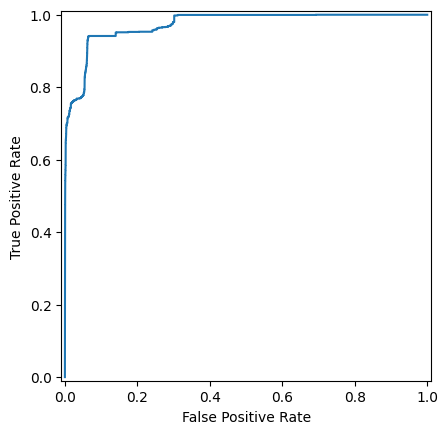

In [71]:
y_score = model.predict_proba(test_features)[:,1]

roc_auc = round(roc_auc_score(test_features_labels["is_phishing"], y_score), 4)
print("roc_auc_score =", roc_auc)
fpr, tpr, _ = roc_curve(test_features_labels["is_phishing"], y_score, pos_label=model.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [10]:
%%time

CV_FOLD_PERC = 0.8
N_FOLDS = 5

f1_scores = []
for fold in range(N_FOLDS):
    print("Fold", fold + 1)
    x_train = train_features.sample(frac=CV_FOLD_PERC)
    x_train_labels = x_train.loc[:, []].join(train_features_labels, how="left")
    x_validation = validation_features.sample(frac=CV_FOLD_PERC)
    x_validation_labels = x_validation.loc[:, []].join(validation_features_labels, how="left")
    model_fold = train_model(
        x_train, x_train_labels["is_phishing"].values, 
        x_validation, x_validation_labels["is_phishing"].values,
        cv=True
    )
    y_test_predicted = model_fold.predict(test_features)
    f1_cv = f1_score(test_features_labels["is_phishing"], y_test_predicted) * 100
    print(
        round(f1_cv, 2),
        round(recall_score(test_features_labels["is_phishing"], y_test_predicted) * 100, 2)
    )
    f1_scores.append(f1_cv)

Fold 1
Best iteration: 61

61.91 55.91
Fold 2
Best iteration: 55

61.33 56.07
Fold 3
Best iteration: 52

59.99 56.01
Fold 4
Best iteration: 51

59.45 55.56
Fold 5
Best iteration: 60

58.95 53.98
CPU times: user 13h 58min 36s, sys: 1h 4min 4s, total: 15h 2min 41s
Wall time: 1h 40min 59s


In [17]:
gfp_best = 51.49
gfp_std = 4.29

In [19]:
print(f"GFP best: {gfp_best} ± {gfp_std}")

GFP best: 51.49 ± 4.29


In [15]:
print(f"{round(f1_final, 2)} ±{round(np.std(f1_scores), 2)}")

61.83 ±1.12


In [18]:
uplift = round(((f1_final - gfp_best) / gfp_best) * 100, 2)
print(f"Uplift of {uplift}%")

Uplift of 20.08%
